In [1]:
print("all ok")

all ok


In [2]:
import os
# Adding ENV Variables
os.environ["GROQ_API_KEY"] = ""
os.environ["GOOGLE_API_KEY"] = ""
os.environ["OPENAI_API_KEY"] = ""
os.environ["LLM_PROVIDER"] = "groq"

In [ ]:
# import sys, os
#
# # Get project root — one level up from 'research_and_analyst'
# project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
# sys.path.append(project_root)
#
# print("Project root added to path:", project_root)

In [3]:
from research_and_analyst.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2025-11-05T17:56:23.819454Z", "level": "warning", "event": "OPENAI_API_KEY is missing from environment"}
{"timestamp": "2025-11-05T17:56:23.819454Z", "level": "warning", "event": "GOOGLE_API_KEY is missing from environment"}
{"timestamp": "2025-11-05T17:56:23.819454Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-11-05T17:56:23.829651Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-11-05T17:56:23.829651Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-11-05T17:56:23.829651Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-05T17:56:23.851464Z", "level": "info", "event": "YAML config loaded"}


In [5]:
llm=model_loader.load_llm()

{"provider": "groq", "model": "openai/gpt-oss-120B", "timestamp": "2025-11-05T17:56:31.411620Z", "level": "info", "event": "Loading LLM"}


In [6]:
llm.invoke("hi").content

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I help you today?'

In [17]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [20]:
# ---- StateGraph ------ #
# StateGraph is the core class of the langgraph library.
# StateGraph allows you to define graph based workflow for your AI System - where each node represents a step/function in the process.
# We can connect these node with transitions (edges) to control how data flows between them.
# Think of it like a flow chart for reasoning.

# ---- START & END ------ #
# These are special node constants in langgraph used to define entry point & final exit point of the graph.
from langgraph.graph import StateGraph, START, END

# ----- Langchain_core.message --------- #
# These comes from langchain message schema used to represent structured chat messages exchanged between:
# 1. The user (human) 2. the assistant (AI) 3. the system (context or instructions)
# Langgraph often uses Langchain Messages to represent the "state" being passed between nodes.

# HumanMessage - represents what a user says
# AIMessage - Represents what the AI assistant replies.
# SystemMessage - Used to define context, rules, or behavior for the AI model.
"""
🧠 Why they’re useful

LangChain’s Message classes keep your chat or reasoning flow structured.
Instead of raw strings, each message type carries semantic meaning — so you can easily log, replay, or analyze the interaction.
"""
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
"""
🧩 3️⃣ from langgraph.checkpoint.memory import MemorySaver
✅ MemorySaver

This class helps store and restore the state of your LangGraph execution.

LangGraph graphs can have checkpoints, so if your workflow is paused or fails midway, you can resume from where it left off.

MemorySaver is the simplest form — it keeps checkpoints in memory (RAM).

🧠 In production, you might use other check pointers (like Redis or a database), but MemorySaver is perfect for local testing or demos.

"""
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [22]:
"""
The @property decorator in Python allows you to define a method inside a class that behaves like a read-only attribute.

So instead of calling it like a function: analyst.persona(), we can access it like a simple variable : analyst.persona

But behind the scenes, Python actually runs a method (the one under @property) every time you access it.

** Useful when value depends on other attributes (Use case - Compute values dynamically from other fields)
"""
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

In [24]:
analyst = Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [25]:
analyst.name

'sunny savita'

In [26]:
analyst.role

'genai eng'

In [27]:
analyst.affiliation

'AI Research LAB'

In [28]:
print(analyst.persona)

Name: sunny savita
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [29]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [30]:
class GenerateAnalystsState(TypedDict):  # TypedDict means you can access it via dict.
    topic: str # research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [31]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [33]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [34]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please explain only on topic AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease explain only on topic AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [39]:
def create_analyst(state: GenerateAnalystsState):
    """
    it is creating my analyst
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [40]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Maya Patel', role='Public Health Policy Analyst', affiliation='World Health Organization (WHO)', description='Focuses on global health policy, disease prevention strategies, and health equity. Concerned with evidence-based policy making, pandemic preparedness, and the impact of socioeconomic factors on health outcomes.'),
  Analyst(name='Alex Rivera', role='Digital Health & Wellness Analyst', affiliation='Stanford Center for Digital Health Innovation', description='Specializes in emerging health technologies, telemedicine, wearable health devices, and personalized wellness. Motivated by improving individual health outcomes through data-driven tools and addressing privacy and accessibility challenges.')]}

In [41]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [42]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [ ]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

In [43]:
from IPython.display import Image, display

## First Workflow

In [44]:
builder = StateGraph(GenerateAnalystsState)

In [45]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [46]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [47]:
memory = MemorySaver()

In [48]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

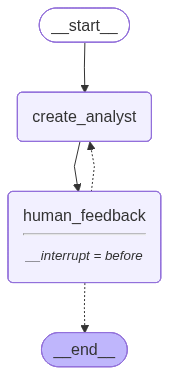

In [49]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [50]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [51]:
max_analysts = 4

In [52]:
thread =  {"configurable":{"thread_id":1}}

In [53]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Patel
Affiliation: Institute for Scalable AI Systems
Role: Performance & Scalability Analyst
Description: Focuses on benchmarking Langgraph's runtime efficiency, concurrency handling, and resource utilization compared to alternative agent frameworks. Concerned with latency, throughput, and scalability in large‑scale deployments.
--------------------------------------------------
Name: Alex Chen
Affiliation: OpenAI Developer Relations
Role: Developer Experience Analyst
Description: Evaluates the ergonomics, learning curve, and tooling around Langgraph. Looks at documentation quality, API design, debugging support, and how quickly engineers can prototype and iterate on agent workflows.
--------------------------------------------------
Name: Prof. Elena García
Affiliation: Center for Interoperable AI
Role: Integration & Ecosystem Analyst
Description: Assesses Langgraph's compatibility with existing LLM providers, data pipelines, and orchestration platforms. Explores plug‑i

In [86]:
state = graph.get_state(thread)

In [87]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description='Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary concern is how Langgraph can enhance the efficiency and scalability of AI systems. She is motivated by the potential for Langgraph to streamline complex AI processes and improve integration with existing technologies.'), Analyst(name='Raj Patel', role='Enterprise Solutions Consultant', affiliation='Tech Innovators Inc.', description='Raj Patel examines the business benefits of implementing Langgraph in enterprise environments. His focus is on cost reduction, improved productivity, and the competitive edge that Langgraph can provide to businesses. He is particularly interested in how Langgraph can facilitate smoother transitions to AI-driven op

In [88]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description='Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary concern is how Langgraph can enhance the efficiency and scalability of AI systems. She is motivated by the potential for Langgraph to streamline complex AI processes and improve integration with existing technologies.'),
  Analyst(name='Raj Patel', role='Enterprise Solutions Consultant', affiliation='Tech Innovators Inc.', description='Raj Patel examines the business benefits of implementing Langgraph in enterprise environments. His focus is on cost reduction, improved productivity, and the competitive edge that Langgraph can provide to businesses. He is particularly interested in how Langgraph can facilitate smoother transitions to AI-driven operations.'),
  An

In [89]:
state.next

('human_feedback',)

In [90]:
# memory.storage

In [49]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0a6700-4ee8-6fab-bfff-35c89d918f29': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-11T07:00:49.777655+00:00\xa2id\xd9$1f0a6700-4ee8-6fab-bfff-35c89d918f29\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.3352191460678753\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0a6700-4ee8-6fac-8000-9105dc8ad9ff': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-11T07:00:49.777655+00:00\xa2id\xd9$1f0a6700-4ee8-6fac-8000-9105dc8ad9ff\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.5440664990174531\xa5topic\xd9300000000000000000000000000000002.0.5440664990174531\xacmax_analysts\xd9300000000000000000000000000000002.0.5440664990174531\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.5440664990174531\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\xd

In [91]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [92]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a676e-584e-6ae7-8001-095e48a27bf2'}}

In [93]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a676f-114d-6612-8002-10bb8aa31dd2'}}

In [94]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary concern is how Langgraph can enhance the efficiency and scalability of AI systems. She is motivated by the potential for Langgraph to streamline complex AI processes and improve integration with existing technologies.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: Enterprise Solutions Consultant
Description: Raj Patel examines the business benefits of implementing Langgraph in enterprise environments. His focus is on cost reduction, improved productivity, and the competitive edge that Langgraph can provide to businesses. He is particularly interested in how Langgraph can facilitate smoother transitions to AI-driven operations.
--------------------------------------------------
Name: Dr. Sofia Martinez
Affiliation: Glob

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in the cost-effectiveness and scalability of Langgraph for new businesses, and how it can accelerate product development cycles.
--------------------------------------------------
Name: Raj Patel
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on the framework's ability to enhance operational efficiency, improve data handling, and support complex workflows in established businesses.
--------------------------------------------------
Name: Elena Garcia
Affiliation: Institute of Advanced AI Studies
Role: AI Framework Researcher
Description: Elena's research delves into the technical benefits of adop

In [95]:
state = graph.get_state(thread)

In [96]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in the cost-effectiveness and scalability of Langgraph for new businesses, and how it can accelerate product development cycles.'), Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description="Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on the framework's ability to enhance operational efficiency, improve data handling, and support complex workflows in established business

In [97]:
state.next

('human_feedback',)

In [98]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in the cost-effectiveness and scalability of Langgraph for new businesses, and how it can accelerate product development cycles.'),
  Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description="Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on the framework's ability to enhance operational efficiency, improve data handling, and support complex workflows in established businesses."),
  Analyst

In [99]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [103]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [104]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [105]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a6772-c57f-6303-8006-584c83de552a'}}

In [107]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [108]:
analysts = final_state.values.get('analysts')

In [109]:
analysts

[Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in the cost-effectiveness and scalability of Langgraph for new businesses, and how it can accelerate product development cycles.'),
 Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description="Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on the framework's ability to enhance operational efficiency, improve data handling, and support complex workflows in established businesses."),
 Analyst(name='Elena Garcia', role='AI Framework Researcher', affiliation='Institute of Advanced AI Studies', description="Elena's research delves into the technical benefits of adopting Langgraph as an agent framework. She is intere

In [111]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in the cost-effectiveness and scalability of Langgraph for new businesses, and how it can accelerate product development cycles.
--------------------------------------------------
Name: Raj Patel
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on the framework's ability to enhance operational efficiency, improve data handling, and support complex workflows in established businesses.
--------------------------------------------------
Name: Elena Garcia
Affiliation: Institute of Advanced AI Studies
Role: AI Framework Researcher
Description: Elena's research delves into the technical benefits of adop

In [113]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


## Second Workflow

In [151]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [162]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [163]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

In [164]:
tavily_search.invoke("langgraph")

[{'title': 'LangGraph: A Framework for Building Stateful Multi-Agent LLM ...',
  'url': 'https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03',
  'content': '> LangGraph is a powerful Python library designed for constructing stateful, multi-actor applications with Large Language Models (LLMs). It extends the capabilities of LangChain Expression Language (LCEL) while specifically addressing limitations in existing frameworks for agent development. As a specialized tool for creating complex LLM applications, LangGraph provides a structured approach to building sophisticated workflows that require cyclical processing patterns. [...] LangGraph represents a significant advancement in the toolkit available for developing sophisticated LLM applications, particularly those involving agent-like behaviors and multi-agent coordination. By extending LangChain with support for cyclical workflows and robust state management, it addresses k

In [165]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 

In [242]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [243]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [174]:
print(analyst.persona)

Name: Michael Chen
Role: Business Strategy Consultant
Affiliation: FutureTech Consulting
Description: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.



In [175]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you

In [ ]:
'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.'

In [244]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [180]:
analyst

Analyst(name='Michael Chen', role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.')

In [245]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [193]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [194]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Michael Chen', role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [196]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [202]:
result

{'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reaso

In [200]:
print(result["messages"][0].content)

Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. 

To start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?


In [246]:
from langchain_core.messages import get_buffer_string

In [247]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [248]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [208]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [209]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [213]:
print(result["context"][0])

<Document href="https://www.scalablepath.com/machine-learning/langgraph"/>
In fact, the rapid adoption of AI agents by companies indicates a strategic shift. Early movers are using AI agents to handle tasks that were once bottlenecks, gaining an edge in customer responsiveness, data analysis, and innovation capacity. Using a framework like LangGraph ensures these AI initiatives are scalable and maintainable, so one is building a long-term strategic asset, not just a demo or one-off script.

### Practical Gains: Save Time and Money While Reducing Errors [...] Another advantage of the LangGraph approach is that one can precisely control when and how agents interact. The graph’s edges and nodes act like a playbook for the team of agents. One can have phases in the workflow where agents work in parallel, and then points where the workflow pauses and awaits a decision or input. [...] This approach has strong parallels to how human teams work, and indeed some benefits are the same: specializ

In [249]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [225]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [226]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph framework benefits for business innovation and digital transformation'


In [240]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [241]:
search_docs

[]

In [227]:
result

{'context': ['']}

In [250]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [251]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [252]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [253]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [254]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [255]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [260]:
interview_builder = StateGraph(InterviewState)

In [261]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [262]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [263]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


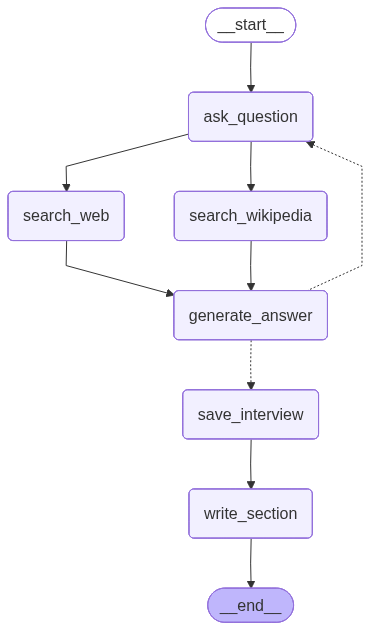

In [264]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [273]:
analyst

Analyst(name='Michael Chen', role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.')

In [274]:
analyst.persona

'Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n'

In [284]:
thread = {"configurable": {"thread_id": "1"}}

In [285]:
from IPython.display import Markdown

In [286]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [287]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph framework business innovation digital transformation challenges implementation'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [288]:
Markdown(interview['sections'][0])

## Langgraph: A Strategic Catalyst for Business Innovation and Transformation

### Summary

In the rapidly evolving landscape of artificial intelligence, businesses are increasingly seeking frameworks that not only drive innovation but also align with long-term strategic goals. Langgraph emerges as a pivotal tool in this context, offering a robust framework for businesses to harness the power of AI-driven automation. This report delves into the strategic implications of adopting Langgraph, highlighting its potential to drive innovation, support digital transformation initiatives, and align with long-term business objectives.

Langgraph stands out due to its ability to automate complex tasks through a graph-based workflow, which allows for a controlled and structured flow of events. This is particularly beneficial for businesses aiming to enhance process automation and customer engagement strategies. By employing virtual agents at various junctures of the business workflow, companies can save time and deliver personalized, high-quality communications [1]. 

One of the novel aspects of Langgraph is its stateful automation, which enables workflows to retain context through shared memory. This feature supports persistent interactions and error recovery, ensuring tasks can pause, resume, or adjust based on real-time inputs. This capability is crucial for businesses as it offers tools for human oversight, such as moderation checkpoints and approval nodes, ensuring compliance and control in sensitive operations [2]. 

Langgraph's modular design is another significant advantage, allowing businesses to scale their automation efforts gradually. New functionalities can be added without disrupting existing workflows, minimizing risks and ensuring smooth operations. This approach simplifies maintenance, making it easier to implement changes and understand each component's role [3]. 

Furthermore, Langgraph's integration with advanced AI models and seamless workflow management enables enterprises to stay ahead in the competitive landscape. By leveraging this technology, businesses can enhance their overall process automation, save time, and deliver personalized, high-quality communications [1]. 

In conclusion, Langgraph offers a strategic edge for businesses by automating and augmenting complex workflows, enabling companies to deliver decisions and services with the speed and responsiveness facilitated by AI. This framework not only addresses the "black box" problem of AI solutions by providing transparency and control but also ensures that AI agents act in alignment with business policies and ethics [4]. 

### Sources
[1] https://walkingtree.tech/empowering-virtual-sales-agents-with-ai-driven-automation-using-langgraph/  
[2] https://latenode.com/blog/what-is-langgraph  
[3] https://medium.com/@kajal.verma/langgraph-building-smarter-ai-agents-with-graph-based-workflows-b520eadfc582  
[4] https://www.scalablepath.com/machine-learning/langgraph  

## third Workflow